In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
df = pd.read_csv("data/data.csv", dtype=str)
print(df.head())

                       title          id
0                   Eksi Bir   8960040_t
1  Mein Freund, der Deutsche   8595106_t
2                    Tähminä   1266112_t
3                     Sarhos   7147756_t
4              Tamiri Mümkün  24517988_t


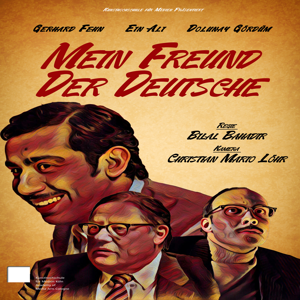

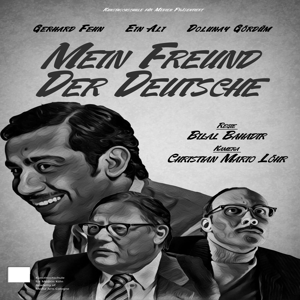

In [3]:
def display_image(image):
    plt.imshow(image.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()
    
def display_image_from_id(image_id, color='c', size=(300, 300)):
    if color == 'b':
        image_path = "data/images_black/" + image_id + ".jpg"
        img = Image.open(image_path)
    else:
        image_path = "data/images_color/" + image_id + ".jpg"
        img = Image.open(image_path)

    # Resize the image to the specified size
    img = img.resize(size)

    display(img)
    
display_image_from_id('8595106_t', 'c')
display_image_from_id('8595106_t', 'b')

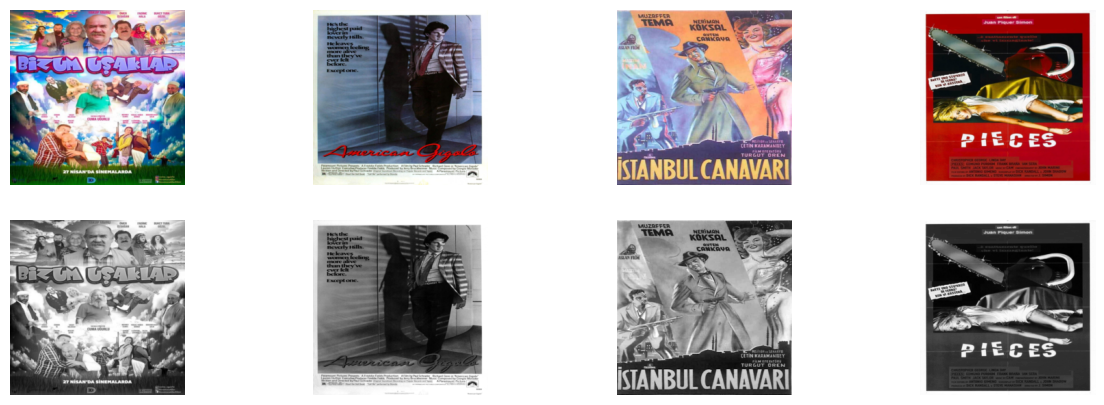

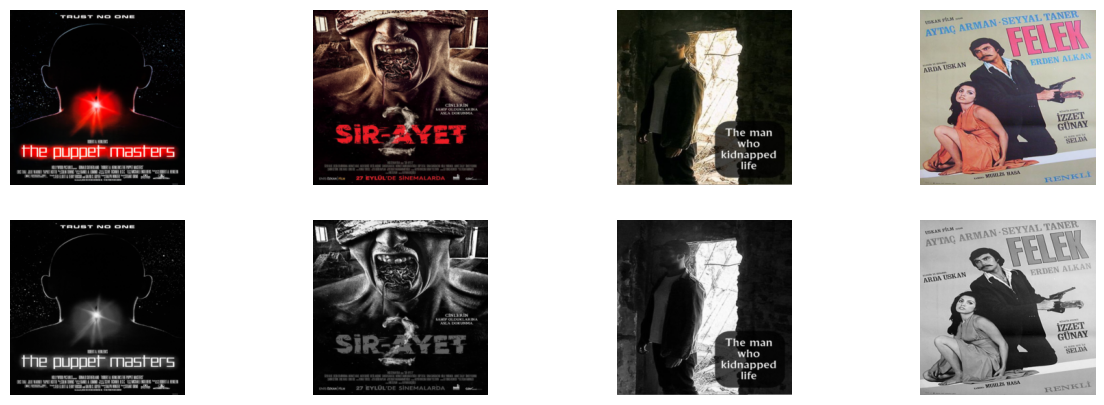

In [4]:
class PhotoDataset(Dataset):
    def __init__(self, root_dir='data/', df=None):
        self.root_dir = root_dir
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root_dir, 'images_color', self.df['id'][idx] + '.jpg'))
        label = Image.open(os.path.join(self.root_dir, 'images_black', self.df['id'][idx] + '.jpg'))

        return image, label

# Custom collate function to handle PIL images with resizing
def custom_collate(batch):
    images, labels = zip(*batch)

    # Resize or pad images to a consistent size
    target_size = (256, 256)
    images = [transforms.Resize(target_size)(image) for image in images]
    labels = [transforms.Resize(target_size)(label) for label in labels]

    images = [transforms.ToTensor()(image) for image in images]
    labels = [transforms.ToTensor()(label) for label in labels]

    return torch.stack(images), torch.stack(labels)

photo_dataset = PhotoDataset(df=df)
batch_size = 4
dataloader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

for idx, batch in enumerate(dataloader):

    plt.figure(figsize=(15, 5))

    for i in range(batch[0].size(0)):
        # Display input image
        plt.subplot(2, batch[0].size(0), i + 1)
        plt.imshow(batch[0][i].permute(1, 2, 0), cmap='gray')
        plt.axis("off")

        # Display corresponding label
        plt.subplot(2, batch[0].size(0), i + 1 + batch[0].size(0))
        plt.imshow(batch[1][i].permute(1, 2, 0), cmap='gray')
        plt.axis("off")

    plt.show()

    if idx == 1:
        break


In [5]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        # Define your model architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 2, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
model = ColorizationModel()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Custom collate function to handle PIL images with resizing
def custom_collate(batch):
    images, labels = zip(*batch)

    # Resize or pad images to a consistent size
    target_size = (256, 256)
    images = [transforms.Resize(target_size)(image) for image in images]
    labels = [transforms.Resize(target_size)(label) for label in labels]

    images = [transforms.Grayscale(num_output_channels=1)(image) for image in images]
    labels = [transforms.Grayscale(num_output_channels=1)(label) for label in labels]

    images = [transforms.ToTensor()(image) for image in images]
    labels = [transforms.ToTensor()(label) for label in labels]

    return torch.stack(images), torch.stack(labels)

# Use the entire dataset
# df = # Your full dataset

photo_dataset = PhotoDataset(df=df)
batch_size = 32  # or another suitable batch size for your hardware
dataloader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

# Training loop
num_epochs = 10  # or adjust based on your training needs
for epoch in range(num_epochs):
    for idx, batch in enumerate(dataloader):
        inputs, targets = batch

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        if idx % 10 == 0:
            print(f"Epoch: {epoch + 1}, Batch: {idx + 1}, Loss: {loss.item()}")

# Visualize results
for idx, batch in enumerate(dataloader):
    inputs, targets = batch

    # Forward pass
    outputs = model(inputs)

    plt.figure(figsize=(15, 5))

    for i in range(batch[0].size(0)):
        # Display input image
        plt.subplot(2, batch[0].size(0), i + 1)
        plt.imshow(batch[0][i].squeeze(), cmap='gray')
        plt.axis("off")

        # Display predicted colorized image
        plt.subplot(2, batch[0].size(0), i + 1 + batch[0].size(0))
        plt.imshow(outputs[i].permute(1, 2, 0).detach().numpy())
        plt.axis("off")

    plt.show()

    if idx == 1:
        break

C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 256, 256])) that is different to the input size (torch.Size([32, 2, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1, Batch: 1, Loss: 0.3246089220046997


KeyboardInterrupt: 

In [9]:
from PIL import Image
import os
import pandas as pd

def remove_large_images(folder_path_color, folder_path_black, csv_path, threshold_pixels, additional_images=None):
    large_images_count = 0

    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_path)

    # List of additional image filenames to remove
    if additional_images is None:
        additional_images = ["24990632_t.jpg", "5830248_t.jpg"]

    # Iterate through files in the 'data/images_color' folder
    for file_name in os.listdir(folder_path_color):
        file_path_color = os.path.join(folder_path_color, file_name)
        file_path_black = os.path.join(folder_path_black, file_name)

        # Check if the file is an image
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                # Open the image and get its dimensions
                with Image.open(file_path_color) as img:
                    width, height = img.size
                    total_pixels = width * height

                    # Check if the image has more pixels than the threshold
                    if total_pixels > threshold_pixels or file_name in additional_images:
                        large_images_count += 1
                        print(f"Removing image with filename {file_name}.")

                        # Close the image
                        img.close()

                        # Remove the image files
                        os.remove(file_path_color)
                        os.remove(file_path_black)

                        # Remove the corresponding entry from the DataFrame
                        df = df[df['id'] != file_name.split('.')[0]]
            except Exception as e:
                print(f"Error processing {file_name}: {str(e)}")

    # Save the updated DataFrame back to the CSV file
    df.to_csv(csv_path, index=False)

    print(f"Total number of images removed: {large_images_count}")

# Example usage:
folder_path_color = 'data/images_color'
folder_path_black = 'data/images_black'
csv_path = 'data/data.csv'
threshold_pixels = 89478485
additional_images_to_remove = ['specific_image1.jpg', 'specific_image2.jpg']

remove_large_images(folder_path_color, folder_path_black, csv_path, threshold_pixels, additional_images=additional_images_to_remove)


Error processing 24990632_t.jpg: Image size (216000000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Error processing 5830248_t.jpg: Image size (203440600 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Total number of images removed: 0
